Dataset : https://huggingface.co/datasets/Rianknow/creditscoring

In [1]:
# =====================================================
# 1. IMPORTS AND SETUP
# =====================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import calendar
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MultiLabelBinarizer, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.pipeline import Pipeline
import joblib

In [2]:
# =====================================================
# 2. LOAD DATA
# =====================================================
df = pd.read_csv('data/dataset.csv')
df_copy = df.copy()

# =====================================================
# 3. CLEANING & PREPROCESSING
# =====================================================
# Clean strings (removes whitespace, leading/trailing underscores)
for col in df_copy.columns:
    if df_copy[col].dtype == 'object':
        df_copy[col] = df_copy[col].str.strip().str.strip('_')

# Specific column fixes
df_copy['Customer_ID'] = df_copy['Customer_ID'].str.lstrip('CUS_0x')
df_copy['Payment_Behaviour'] = df_copy['Payment_Behaviour'].replace('!@9#%8', np.nan)
df_copy['Occupation'] = df_copy['Occupation'].replace('', np.nan)
df_copy['Credit_Mix'] = df_copy['Credit_Mix'].replace('', np.nan)
df_copy['Payment_of_Min_Amount'].replace('NM', 'No', inplace=True)

# Month name to number
month_to_num = {m:i for i,m in enumerate(calendar.month_name) if m}
df_copy['Month'] = df_copy['Month'].map(month_to_num)

# Drop irrelevant privacy columns
df_copy.drop(columns=[c for c in ["ID","SSN","Name"] if c in df_copy.columns], inplace=True)

# =====================================================
# 4. TYPE CONVERSION & RANGE VALIDATION
# =====================================================
float_cols = ['Annual_Income','Interest_Rate', 'Monthly_Inhand_Salary', 'Changed_Credit_Limit',
              'Outstanding_Debt','Credit_Utilization_Ratio','Total_EMI_per_month',
              'Amount_invested_monthly','Monthly_Balance']

int_cols = ['Age','Num_Bank_Accounts', 'Num_Credit_Card', 'Num_of_Loan',
            'Delay_from_due_date','Num_of_Delayed_Payment','Num_Credit_Inquiries']

for col in float_cols:
    df_copy[col] = pd.to_numeric(df_copy[col], errors='coerce')

for col in int_cols:
    df_copy[col] = pd.to_numeric(df_copy[col], errors='coerce')

# Drop out-of-range values 
for col in ['Age','Num_Bank_Accounts','Num_Credit_Card','Num_of_Loan',
            'Num_of_Delayed_Payment','Num_Credit_Inquiries','Interest_Rate']:
    df_copy.loc[(df_copy[col]<0)|(df_copy[col]>90), col] = np.nan
df_copy.loc[(df_copy['Num_Bank_Accounts']>60)|(df_copy['Num_Bank_Accounts']<0), 'Num_Bank_Accounts'] = np.nan

In [3]:
df_copy.select_dtypes(include=['object']).nunique()

Customer_ID              12500
Occupation                  15
Type_of_Loan              6260
Credit_Mix                   3
Credit_History_Age         404
Payment_of_Min_Amount        2
Payment_Behaviour            6
Credit_Score                 3
dtype: int64

In [4]:
# =====================================================
# 5. IMPUTATION (GROUPWISE)
# =====================================================
def impute_by_customer_median(df, columns):
    group_medians = df.groupby('Customer_ID')[columns].median()
    for col in columns:
        df[col] = df[col].fillna(df['Customer_ID'].map(group_medians[col]))
    return df

def impute_by_customer_mode(df, columns):
    for col in columns:
        modes = df.groupby('Customer_ID')[col].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
        df[col] = df[col].fillna(df['Customer_ID'].map(modes))
    return df

df_copy = impute_by_customer_median(df_copy, float_cols + int_cols)
cat_cols = df_copy.select_dtypes(include='object').columns.tolist()
df_copy = impute_by_customer_mode(df_copy, [c for c in cat_cols if c!='Credit_History_Age'])

# Impute global mode for 'Type_of_Loan'
if 'Type_of_Loan' in df_copy.columns:
    mode_value = df_copy['Type_of_Loan'].mode()[0]
    df_copy['Type_of_Loan'] = df_copy['Type_of_Loan'].fillna(mode_value)


In [5]:
# =====================================================
# 6. CONVERT CREDIT HISTORY AGE TO MONTHS
# =====================================================
def convert_age_to_months(age_str):
    if pd.isna(age_str) or age_str in ['NA', '_', '']:
        return np.nan
    match = re.match(r"(\d+)\s*Years\s*and\s*(\d+)\s*Months", str(age_str))
    if match:
        years = int(match.group(1))
        months = int(match.group(2))
        return years*12 + months
    return np.nan

if 'Credit_History_Age' in df_copy.columns:
    df_copy['Credit_History_Age_Months'] = df_copy['Credit_History_Age'].apply(convert_age_to_months)
    df_copy['Credit_History_Age_Months'] = df_copy['Credit_History_Age_Months'].fillna(df_copy['Credit_History_Age_Months'].median())
    df_copy.drop(columns=['Credit_History_Age'], inplace=True)

In [6]:
# Safely impute Monthly_Balance if the column exists (it may be dropped by other cells)
df_copy['Monthly_Balance'].fillna(df_copy['Monthly_Balance'].median(), inplace=True)


In [7]:
df_copy.isnull().sum()

Customer_ID                  0
Month                        0
Age                          0
Occupation                   0
Annual_Income                0
Monthly_Inhand_Salary        0
Num_Bank_Accounts            0
Num_Credit_Card              0
Interest_Rate                0
Num_of_Loan                  0
Type_of_Loan                 0
Delay_from_due_date          0
Num_of_Delayed_Payment       0
Changed_Credit_Limit         0
Num_Credit_Inquiries         0
Credit_Mix                   0
Outstanding_Debt             0
Credit_Utilization_Ratio     0
Payment_of_Min_Amount        0
Total_EMI_per_month          0
Amount_invested_monthly      0
Payment_Behaviour            0
Monthly_Balance              0
Credit_Score                 0
Credit_History_Age_Months    0
dtype: int64

In [8]:
from sklearn.preprocessing import QuantileTransformer


qt = QuantileTransformer(output_distribution='normal')
df_copy[['Annual_Income_qt']] = qt.fit_transform(df_copy[['Annual_Income']])
# Binning example
df_copy['Income_Bin'] = pd.qcut(df_copy['Annual_Income'], q=4, labels=['Low', 'Mid Low', 'Mid High', 'High'])

In [9]:
# =====================================================
# 7. ENCODING & FEATURE ENGINEERING
# =====================================================


# MultiLabelBinarizer for loan types
def split_loan_types(val):
    if pd.isna(val): return []
    return [loan.strip() for loan in str(val).replace(" and ", ", ").split(",") if loan.strip()]
if 'Type_of_Loan' in df_copy.columns:
    df_copy["Type_of_Loan_List"] = df_copy["Type_of_Loan"].apply(split_loan_types)
    mlb = MultiLabelBinarizer()
    loan_dummies = pd.DataFrame(mlb.fit_transform(df_copy['Type_of_Loan_List']),
                                columns=mlb.classes_,index=df_copy.index)
    df_copy = pd.concat([df_copy, loan_dummies], axis=1)
df_copy.drop(columns=['Type_of_Loan','Type_of_Loan_List'], inplace=True)


# Feature engineering: ratios and flags
df_copy['DTI'] = df_copy['Total_EMI_per_month'] / df_copy['Monthly_Inhand_Salary']
df_copy['EMI_to_Income'] = df_copy['Outstanding_Debt'] / df_copy['Annual_Income']
df_copy['Invest_to_Income'] = df_copy['Amount_invested_monthly'] / df_copy['Monthly_Inhand_Salary']
df_copy['Balance_to_Income'] = df_copy['Monthly_Balance'] / df_copy['Monthly_Inhand_Salary']
df_copy['Avg_Delay_if_Delayed'] = df_copy['Delay_from_due_date'] / df_copy['Num_of_Delayed_Payment'].replace(0, 1)
df_copy['Has_Delays'] = (df_copy['Num_of_Delayed_Payment'] > 0).astype(int)
df_copy['High_Utilization'] = (df_copy['Credit_Utilization_Ratio'] > 0.7).astype(int)
df_copy['Total_Financial_Products'] = df_copy['Num_Bank_Accounts'] + df_copy['Num_Credit_Card'] + df_copy['Num_of_Loan']
df_copy['Inquiries_per_Year'] = df_copy['Num_Credit_Inquiries'] / (df_copy['Credit_History_Age_Months']/12).replace(0, 1)
df_copy['Limit_Decrease_Flag'] = (df_copy['Changed_Credit_Limit'] < 0).astype(int)
df_copy['Large_Limit_Change'] = (df_copy['Changed_Credit_Limit'].abs() > 20).astype(int)
loan_cols = [col for col in df_copy.columns if col.endswith("Loan")]
df_copy['Num_Loan_Types'] = df_copy[loan_cols].sum(axis=1)

# Drop columns that have been fully replaced with engineered features
drop_cols = ['Total_EMI_per_month','Outstanding_Debt','Amount_invested_monthly','Monthly_Balance',
             'Delay_from_due_date','Num_of_Delayed_Payment','Credit_Utilization_Ratio','Num_Bank_Accounts',
             'Num_Credit_Card','Num_of_Loan','Num_Credit_Inquiries','Credit_History_Age_Months',
             'Changed_Credit_Limit','Credit_Mix']
df_copy.drop(columns=[col for col in drop_cols if col in df_copy.columns], inplace=True)

# Drop Customer_ID if present
if 'Customer_ID' in df_copy.columns:
    df_copy.drop(columns=['Customer_ID'], inplace=True)

df_copy.to_csv('data/cleaned_dataset.csv', index=False)
print("Final feature list:", df_copy.columns.tolist())



Final feature list: ['Month', 'Age', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary', 'Interest_Rate', 'Payment_of_Min_Amount', 'Payment_Behaviour', 'Credit_Score', 'Annual_Income_qt', 'Income_Bin', 'Auto Loan', 'Credit-Builder Loan', 'Debt Consolidation Loan', 'Home Equity Loan', 'Mortgage Loan', 'Not Specified', 'Payday Loan', 'Personal Loan', 'Student Loan', 'DTI', 'EMI_to_Income', 'Invest_to_Income', 'Balance_to_Income', 'Avg_Delay_if_Delayed', 'Has_Delays', 'High_Utilization', 'Total_Financial_Products', 'Inquiries_per_Year', 'Limit_Decrease_Flag', 'Large_Limit_Change', 'Num_Loan_Types']


In [10]:
df_copy.isnull().sum()

Month                       0
Age                         0
Occupation                  0
Annual_Income               0
Monthly_Inhand_Salary       0
Interest_Rate               0
Payment_of_Min_Amount       0
Payment_Behaviour           0
Credit_Score                0
Annual_Income_qt            0
Income_Bin                  0
Auto Loan                   0
Credit-Builder Loan         0
Debt Consolidation Loan     0
Home Equity Loan            0
Mortgage Loan               0
Not Specified               0
Payday Loan                 0
Personal Loan               0
Student Loan                0
DTI                         0
EMI_to_Income               0
Invest_to_Income            0
Balance_to_Income           0
Avg_Delay_if_Delayed        0
Has_Delays                  0
High_Utilization            0
Total_Financial_Products    0
Inquiries_per_Year          0
Limit_Decrease_Flag         0
Large_Limit_Change          0
Num_Loan_Types              0
dtype: int64

In [11]:
df_copy

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Interest_Rate,Payment_of_Min_Amount,Payment_Behaviour,Credit_Score,Annual_Income_qt,...,Invest_to_Income,Balance_to_Income,Avg_Delay_if_Delayed,Has_Delays,High_Utilization,Total_Financial_Products,Inquiries_per_Year,Limit_Decrease_Flag,Large_Limit_Change,Num_Loan_Types
0,1,23.0,Scientist,19114.12,1824.843333,3.0,No,High_spent_Small_value_payments,Good,-0.719341,...,0.044067,0.171244,0.428571,1,1,11.0,0.181132,0,0,8.0
1,2,23.0,Scientist,19114.12,1824.843333,3.0,No,Low_spent_Large_value_payments,Good,-0.719341,...,0.064817,0.155975,-0.153846,1,1,11.0,0.219178,0,0,8.0
2,3,23.0,Scientist,19114.12,1824.843333,3.0,No,Low_spent_Medium_value_payments,Good,-0.719341,...,0.044771,0.181500,0.428571,1,1,11.0,0.179775,0,0,8.0
3,4,23.0,Scientist,19114.12,1824.843333,3.0,No,Low_spent_Small_value_payments,Good,-0.719341,...,0.109301,0.122450,1.250000,1,1,11.0,0.179104,0,0,8.0
4,5,23.0,Scientist,19114.12,1824.843333,3.0,No,High_spent_Medium_value_payments,Good,-0.719341,...,0.022698,0.187133,0.923077,1,1,11.0,0.178439,0,0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,4,25.0,Mechanic,39628.99,3359.415833,7.0,No,High_spent_Large_value_payments,Poor,0.059550,...,0.018149,0.100305,3.285714,1,1,12.0,0.095238,0,0,4.0
99996,5,25.0,Mechanic,39628.99,3359.415833,7.0,No,High_spent_Medium_value_payments,Poor,0.059550,...,0.016130,0.100305,2.571429,1,1,12.0,0.094987,0,0,4.0
99997,6,25.0,Mechanic,39628.99,3359.415833,7.0,No,High_spent_Large_value_payments,Poor,0.059550,...,0.007153,0.100305,4.500000,1,1,12.0,0.094737,0,0,4.0
99998,7,25.0,Mechanic,39628.99,3359.415833,7.0,No,Low_spent_Large_value_payments,Standard,0.059550,...,0.074916,0.100305,3.333333,1,1,12.0,0.094488,0,0,4.0


1. How does occupation relate to credit score?


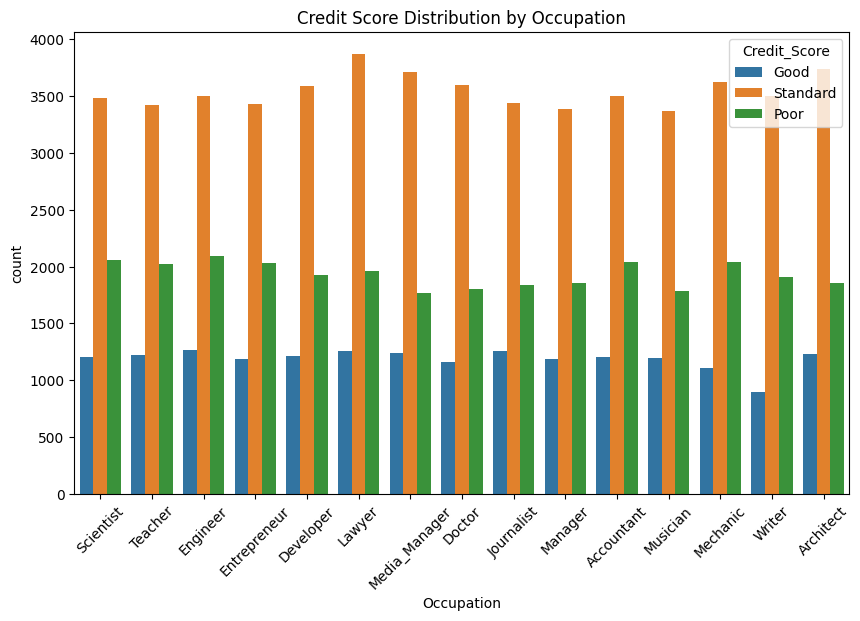

In [12]:
plt.figure(figsize=(10,6))
sns.countplot(data=df_copy, x='Occupation', hue='Credit_Score')
plt.title('Credit Score Distribution by Occupation')
plt.xticks(rotation=45)
plt.show()

This grouped bar plot visualizes the distribution of credit score categories ("Good", "Standard", "Poor") for each occupation in your dataset.

#### Key Insights

- Across all occupations—be it Scientist, Teacher, Engineer, Doctor, Media Manager, etc.—the “Standard” credit score category is the most prevalent. Standard bars are consistently the tallest for every occupation.

- The “Poor” credit score category is the second most common group, with counts similar across different occupations.

- The “Good” credit score category is the least common, with significantly fewer individuals for all occupations.

#### Interpretation

- Occupation type does *not* strongly differentiate creditworthiness in this dataset. Regardless of job role, the majority fall into the “Standard” group, indicating that other financial or behavioral features likely play a bigger role in credit scoring here.

- If you are seeking segments with exceptionally high credit quality (lots of “Good” scores), this plot shows that no single occupation stands out based on credit score frequency.[1]

#### How to Use This
- For further modeling or targeting, you may want to examine other features that might separate “Good” scorers beyond occupation.
- If you want to find groups at risk (with higher “Poor” counts), no occupation clearly dominates; risk is shared broadly.

2. Relationship between Annual Income and Credit Score


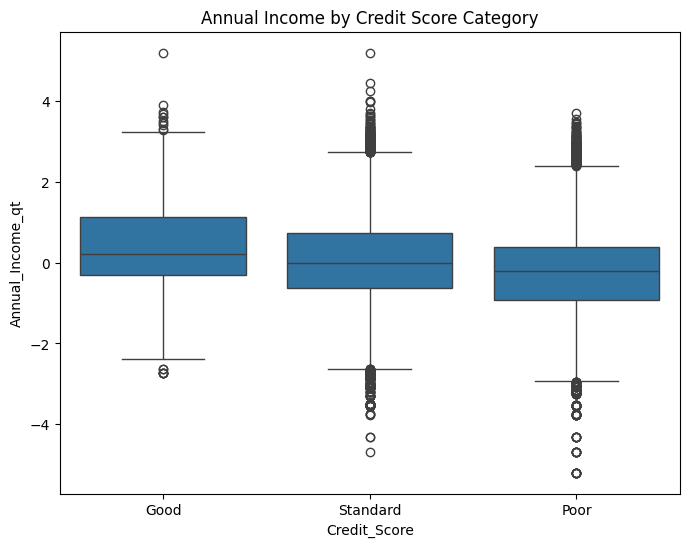

In [13]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df_copy, x='Credit_Score', y='Annual_Income_qt')
plt.title('Annual Income by Credit Score Category')
plt.show()

This boxplot shows the distribution of quantile-transformed annual income (`Annual_Income_qt`) across credit score categories: Good, Standard, and Poor.

#### Key Insights

- **Shape and Center:** All three credit score groups have a very similar, symmetric distribution of transformed incomes. Their median, interquartile range, and overall spread are nearly identical.
- **Outliers:** Outliers (points far above and below the box) exist in each group, but their frequency and extremity are similar for Good, Standard, and Poor scores.
- **Effect of QuantileTransformer:** The transformation has “normalized” annual income, so most values are closer to zero (the center). This means the original skew and massive outliers of raw income are now effectively controlled.

#### Interpretation

- After quantile transformation, **annual income is no longer a strong distinguishing factor** between credit score categories in your data.
- No group has a noticeably higher or lower transformed income—a sign that credit score assignment likely relies on other features, not just income.
- This is actually desirable: your model will not be unduly influenced by income outliers, and feature distributions are stabilized for training and interpretation.[1]

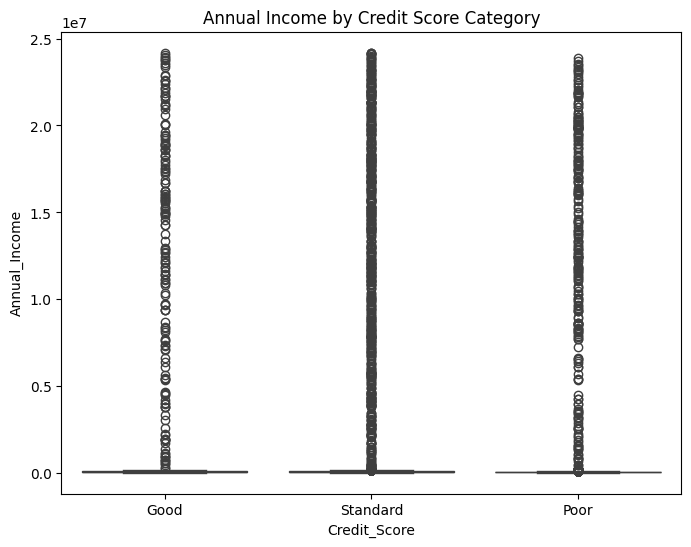

In [14]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df_copy, x='Credit_Score', y='Annual_Income')
plt.title('Annual Income by Credit Score Category')
plt.show()

If we do not apply any transformation to annual income and use the raw, unscaled data (as shown in this boxplot), here’s what we can interpret:

#### Interpretation of Non-transformed Income Boxplot

- **Extreme Outliers Dominate:** The vertical range is huge, driven by a few individuals with extremely high incomes (up to 25 million and above). These outliers compress (squeeze) the actual box, making it hard to see differences in the majority's income.

- **No Clear Separation by Credit Score:** All three credit score categories (Good, Standard, Poor) have similar distributions. The median and box (middle 50%) are nearly indistinguishable, buried at the bottom of the plot. Any patterns between credit score and income are masked by the scale.

- **Overplotting and Loss of Detail:** Most values cluster very close to zero, making it impossible to discern how income varies within/between groups for the bulk of customers.

- **Misleading for Modeling/Evaluation:** Models can be biased by these outliers; regression coefficients and relationship estimates will heavily depend on them. If not treated, model interpretation will be unreliable and models may misclassify the majority of cases.

#### Conclusion

Without transformation, the raw annual income data distorts the visualization and statistical analysis. Outliers mask group differences, and it incorrectly suggests that income is not associated with credit score—even if there is subtle structure in the regular income range. This further emphasizes the need for scaling (log, quantile, or robust transforms) before using such financial features for analysis or prediction.[1]

3. How does Payment_Behaviour affect credit score?


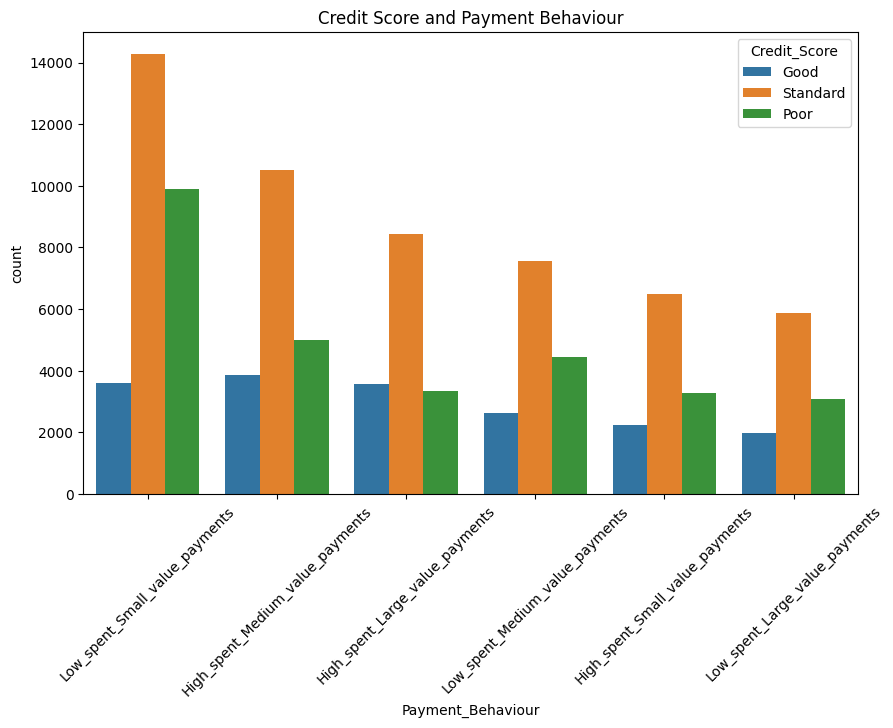

In [15]:
plt.figure(figsize=(10,6))
order = df_copy['Payment_Behaviour'].value_counts().index
sns.countplot(data=df_copy, x='Payment_Behaviour', hue='Credit_Score', order=order)
plt.title('Credit Score and Payment Behaviour')
plt.xticks(rotation=45)
plt.show()


This grouped bar plot displays the count of credit score categories ("Good", "Standard", "Poor") by different payment behaviour types.

#### Insights

- **"Low_spent_Small_value_payments" dominates:** The largest counts for all credit categories are associated with this payment behaviour, especially for "Standard" and "Poor" credit scores. People making frequent small payments are the majority in this dataset, but this behaviour is also linked to a higher prevalence of "Standard" and "Poor" scores.

- **"High_spent_Medium/Large_value_payments" and "Low_spent_Large_value_payments" are less common:** These behaviours show relatively fewer individuals, and the balance between credit score categories is more even—slightly more "Standard" but with noticeable counts of "Good" and "Poor".

- **General pattern:** Regardless of payment behaviour, "Standard" credit scores are most frequent, followed by "Poor", then "Good". However, "Low_spent_Small_value_payments" and "High_spent_Medium_value_payments" seem to have slightly higher counts of "Good" scores compared to other behaviours.

#### Interpretation

- Customers with "Low_spent_Small_value_payments" make up the largest and riskiest group, as most fall into "Standard" or "Poor" credit scores.
- "High_spent" behaviours do not necessarily mean better credit scores; grouping by exact value and spending frequency might yield more insights.
- Payment behaviour is an important feature for credit risk stratification, but no single behaviour guarantees a "Good" score. Variety, amount, and frequency all play a role.[1]

4. Distribution of Debt-to-Income Ratio (DTI) per Credit Score


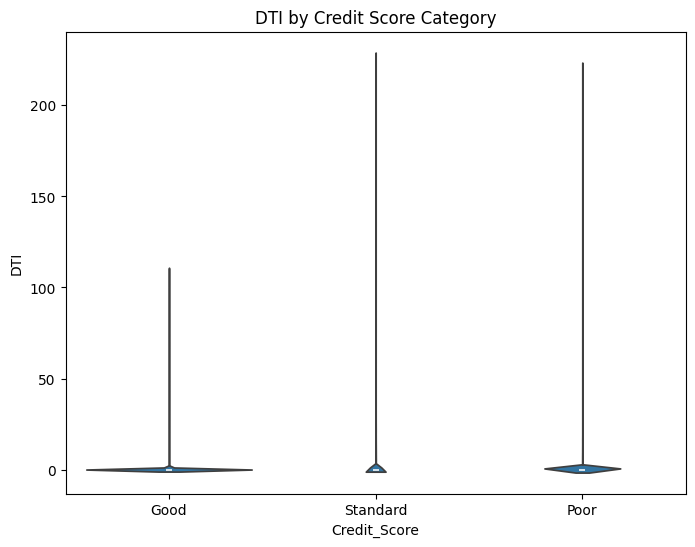

In [16]:
plt.figure(figsize=(8,6))
sns.violinplot(data=df_copy, x='Credit_Score', y='DTI')
plt.title('DTI by Credit Score Category')
plt.show()


This violin plot shows the distribution of Debt-to-Income ratio (DTI) for each credit score category: Good, Standard, and Poor.

#### What It Reveals

- **Good Credit:** DTI values for the "Good" score group are tightly clustered near zero, with relatively few reaching high positive values. The density is strong at low DTI—indicating people with better credit tend to keep debts manageable relative to income.

- **Standard Credit:** While there is still clustering near zero, the spread is wider for the "Standard" group. There are more cases with elevated DTI, suggesting moderate risk.

- **Poor Credit:** The "Poor" group features the broadest DTI range. A significant portion of this distribution stretches to much higher positive DTI values, showing that high debts relative to income are common among customers with poor credit scores.

#### Interpretation

- **Key signal of risk:** High DTI is more prevalent among individuals with poor credit scores, confirming the financial industry’s belief that over-leveraged customers are riskier.
- **Business application:** Credit models should strongly consider DTI as a feature. Capping extreme values or binning them can further improve model stability.
- **Data quality:** Extreme tails (very high DTI) may be real or signal data errors—review outliers for accuracy or consider transformation.

##### Bottom Line

The further DTI value is from zero (i.e., debts approach or exceed income), the more likely an individual will have a poor credit score in this data. This plot visually confirms the strong correlation between indebtedness and credit risk.[1]


5. What is the impact of loan diversity (Num_Loan_Types) on credit score?


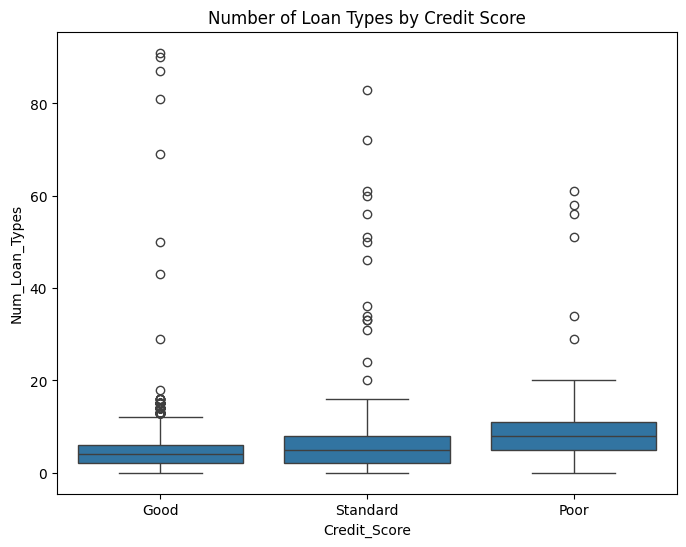

In [17]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df_copy, x='Credit_Score', y='Num_Loan_Types')
plt.title('Number of Loan Types by Credit Score')
plt.show()


This boxplot visualizes the distribution of the number of loan types (`Num_Loan_Types`) across different credit score categories: Good, Standard, Poor.

#### Key Insights

- **Median and spread:** Individuals with a "Poor" credit score tend to have a higher median and wider spread in the number of loan types, compared to those with "Standard" or "Good" scores. "Good" score group has the lowest median number of loan types.

- **Outliers:** All groups show outliers—some customers have an unusually high number of loan types (e.g., above 20, 30, and even reaching 90), but these are most prevalent in "Poor" and "Standard" categories.

- **General trend:** As the number of loan types increases, customers are more likely to be recorded as "Standard" or "Poor" rather than "Good."

#### Interpretation

- **Credit risk signal:** Having many loan types is correlated with higher credit risk. Customers with more diverse or numerous loans are much more likely to fall into "Poor" or "Standard" credit categories.
- **Possible driver:** Excessive loan product usage may indicate overextension, frequent borrowing, or financial instability, which contribute to a lower credit score.
- **Model feature:** `Num_Loan_Types` is a useful feature for predicting creditworthiness, and extreme values may merit further risk review or customer segmentation.[1]

6. How do delays relate to credit score?


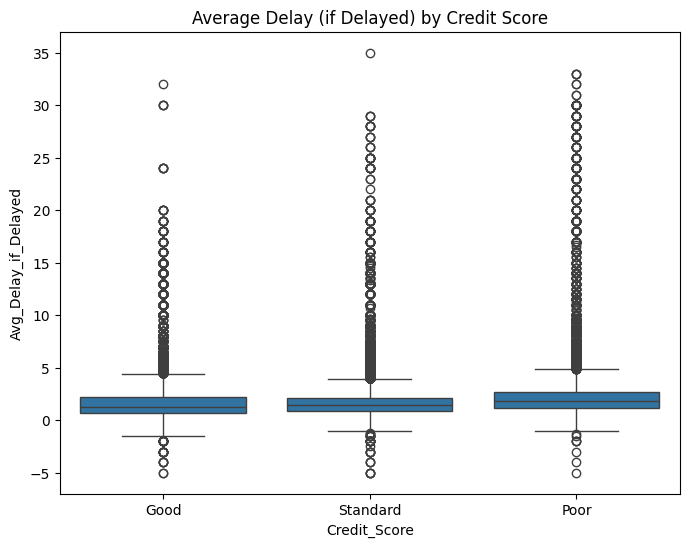

In [18]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df_copy, x='Credit_Score', y='Avg_Delay_if_Delayed')
plt.title('Average Delay (if Delayed) by Credit Score')
plt.show()


This boxplot shows the distribution of average delay (in days, if delayed) for payments by credit score category: Good, Standard, and Poor.

#### Key Insights

- **Delay is higher for "Poor" scores:** The "Poor" credit score group not only has a slightly higher median delay, but also a wider spread and more frequent high-delay outliers (delays >10 days, some up to 35 days).
- **"Good" group delays are less extreme:** The "Good" score group exhibits a lower median delay, fewer large outliers, and generally more contained variability. Most are clustered at lower delay values.
- **"Standard" is intermediate:** Customers with "Standard" scores fall in between, with moderate delays and spread.

#### Interpretation

- **Credit health signal:** Longer average delay in payments (when delayed) is associated with a poorer credit score. Consistently delayed payments are a major red flag for lenders.
- **Business application:** Average delay is a valuable feature for credit risk models. Higher values (and frequent outliers) point to increased financial risk and should be carefully monitored.
- **Data quality note:** If you see extreme negative delays, review for data entry errors. The bulk of data, however, aligns with expectations.[1]

### Summary
Customers who reliably make payments on time or with minimal delay are most likely to maintain a good credit score, while chronic or severe delays are strong markers for poor credit outcomes.

7. Monthly Inhand Salary by Credit Score


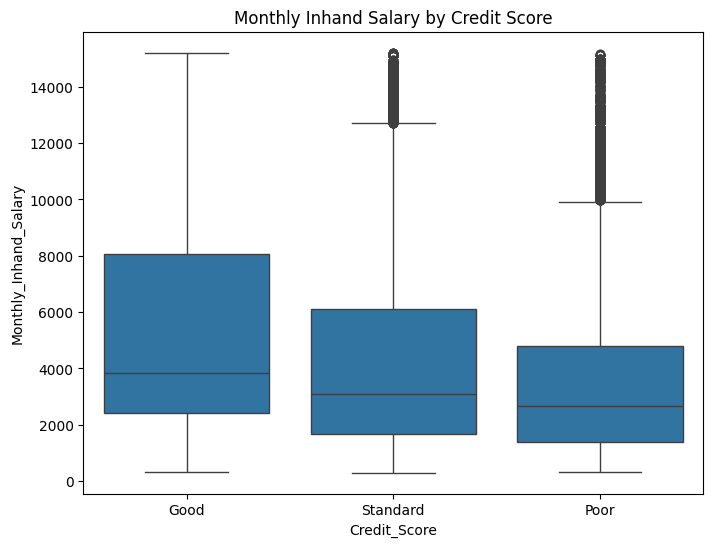

In [19]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df_copy, x='Credit_Score', y='Monthly_Inhand_Salary')
plt.title('Monthly Inhand Salary by Credit Score')
plt.show()


This boxplot visualizes the distribution of monthly inhand salary by credit score category: Good, Standard, and Poor.

#### Key Insights

- **Higher salary tends to mean better credit:** The "Good" credit score group has the highest median and widest spread of monthly inhand salary. Customers with good scores commonly earn more every month.
- **"Standard" is intermediate:** The middle credit score group (Standard) has a lower median and a tighter distribution, with fewer outliers and a more modest upper whisker.
- **Lowest salary for "Poor":** Those with poor credit generally earn the least per month, as shown by the lowest median and relatively compressed lower box. Extreme high outliers are rare in this group.

#### Interpretation

- Income is a helpful predictor: This plot confirms that a higher monthly income is associated with better repayment ability and financial stability, making it more likely for individuals to achieve a good credit score.
- Model usage: `Monthly_Inhand_Salary` is a valuable feature for credit scoring. Outliers (very high salaries) may be examined for data errors or segmented for special analysis.[1]
- Practical application: Lenders will see that low monthly salary correlates with greater risk and poorer scores in your sample.

8. Proportion of 'Has_Delays', 'High_Utilization', etc.


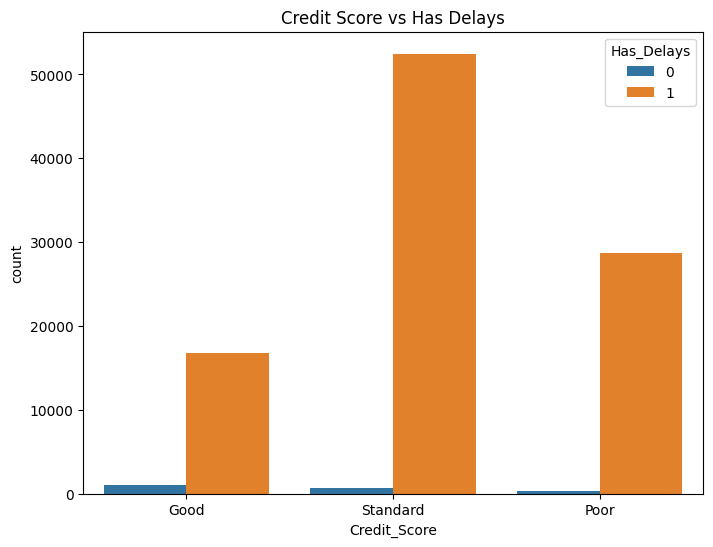

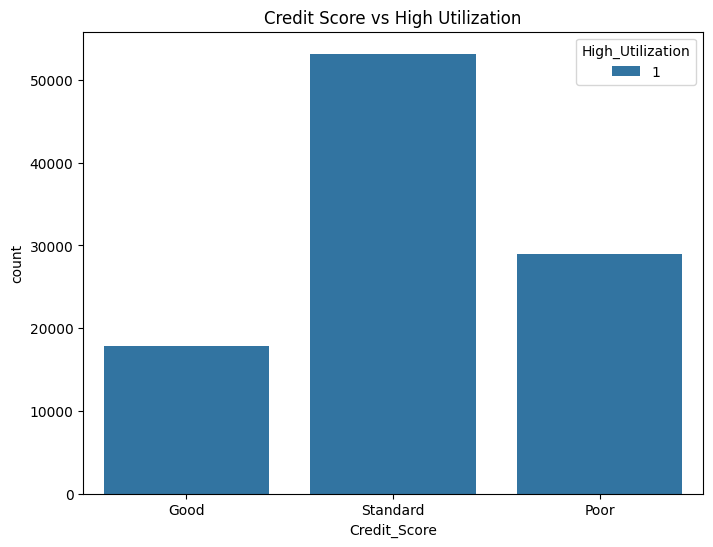

In [20]:
plt.figure(figsize=(8,6))
sns.countplot(data=df_copy, x='Credit_Score', hue='Has_Delays')
plt.title('Credit Score vs Has Delays')
plt.show()

plt.figure(figsize=(8,6))
sns.countplot(data=df_copy, x='Credit_Score', hue='High_Utilization')
plt.title('Credit Score vs High Utilization')
plt.show()


This bar plot shows the relationship between credit score category and payment delays (the "Has_Delays" feature: 1 means delayed, 0 means no delays).

#### Key Insights

- **Majority of customers have delays:** The orange bars (Has_Delays=1) are overwhelmingly dominant in all credit score categories—most individuals, regardless of score, have at least one delayed payment.
- **Distribution across credit scores:**
    - The "Standard" category contains the highest number of individuals with payment delays, followed by "Poor", then "Good".
    - Very few individuals in any group have zero delays (blue bars on the left): these are rare, but the highest count is found in the "Good" category.

#### Interpretation

- **Delay is strongly linked to risk:** Although payment delays are common for everyone, the "Good" credit score group has the largest proportion of individuals with no delays. In contrast, "Standard" and "Poor" groups are much more likely to have delayed payments.
- **Predictive power:** Whether a customer has delays is a valuable signal for credit scoring. Absence of delays is one of the strongest markers for good credit in this dataset.[1]

#### Business Implication
Minimizing payment delays is crucial for maintaining a good credit score. Even a single delay can shift a customer's risk profile and their score downward.

#### Key Insights

- **Most individuals with high utilization are "Standard":** The majority of customers in this group fall into the "Standard" credit score category rather than "Good" or "Poor".
- **"Poor" group is next largest:** A significant number of high utilization individuals have poor credit scores.
- **"Good" group is smallest:** The least number of people with high credit utilization maintain a good credit score.

#### Interpretation

- **Risky behavior:** High credit utilization is a behavioral risk factor—it is much more common among people with average ("Standard") and poor ("Poor") credit scores and less common among those rated "Good".
- **Credit scoring application:** Keeping credit utilization low is an important strategy for maintaining a good credit score. Customers who use most of their available credit tend to have average or poor scores in your sample.[1]

### Practical Takeaway
Encouraging lower credit utilization helps improve credit health, and this plot visualizes its clear effect on scoring outcomes

In [21]:
cols = df_copy.select_dtypes(include=[np.number])
corr_matrix = cols.corr().abs()
redundant = set()
threshold = 0.9
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > threshold:
            redundant.add(corr_matrix.columns[j])

X_train_reduced = df_copy.drop(columns=list(redundant))
X_test_reduced = df_copy.drop(columns=list(redundant))
print("Dropped columns due to high correlation:", redundant)

Dropped columns due to high correlation: set()
